<img src="img/uni_syd_logo.jpg" width="200" height="200" style="float: right" />
# Feed Forward Neural Networks
Dr. Rohitash Chandra and Rafael Possas - Centre of Translational Data Science / Sydney Informatics Hub

In [1]:
import jdc as jdc
import matplotlib.pyplot as plt
import numpy as np
import random
import time
%matplotlib inline

In [2]:
class Network:
    def __init__(self, layers, x_train, y_train, epochs, learning_rate, MinPer):
        self.layers = layers  # NN topology [input, hidden, output]
        self.epochs = epochs  # max epocs or training time
        self.num_samples = len(x_train)

        self.x_train = x_train
        self.y_train = y_train

        self.learning_rate = learning_rate  # will be updated later with BP call
        self.minPerf = MinPer
        # initialize weights ( W1 W2 ) and bias ( b1 b2 ) of the network
        np.random.seed()

        self.w1 = np.random.randn(self.layers[0], self.layers[1])
        self.b1 = np.random.randn(self.layers[1])  # bias first layer
        self.best_b1 = self.b1
        self.best_w1 = self.w1

        self.w2 = np.random.randn(self.layers[1], self.layers[2])
        self.b2 = np.random.randn(self.layers[2])  # bias second layer
        self.best_b2 = self.b2
        self.best_w2 = self.w2

        self.hidden_out = np.zeros(self.layers[1])  # output of first hidden layer
        self.hidden_delta = np.zeros(self.layers[1])  # gradient of first hidden layer

        self.output = np.zeros(self.layers[2])  # output last (output) layer
        self.output_delta = np.zeros(self.layers[2])  # gradient of  output layer

## The Perceptron model - Where it all started
<img src="http://neuralnetworksanddeeplearning.com/images/tikz0.png" width="250" height="250"/>

- Inputs x<sub>1</sub>, x<sub>2</sub>, ..., x<sub>n</sub>
- Outputs are computed using weights w<sub>1</sub>,w<sub>2</sub>, ...,w<sub>n</sub> that expressing the respective importance of the inputs to outputs
- The neuron's output, 0 or 1, is determined by whether the weighted sum ∑<sub>j</sub>w<sub>j</sub>x<sub>j</sub> is less than or greater than some threshold value
<img src="img/perceptron_outputs.png" width="400" height="400"/>

## How a Multi-layer perceptron would look like?

<img src="img/nn_architecture.png" width="500" height="500"/>

- First column of perceptrons is making three simple decisions by weighing the input evidence
- Perceptrons on the second layer are making decisions by weighing at more abstract and complex level when compared to the first layer
- This pattern repeats the deeper you get in the network

## Neuron Example: Sigmoid Neuron

<img src="http://neuralnetworksanddeeplearning.com/images/tikz8.png" width="450" height="450"/>

- Instead of using a linear (weighted) function we could use the sigmoid function that is pretty much a step function that shrinks all the values between 0 and 1, each Neuron would activate the closer the resulting value of the sigmoid is to 1
- To put it all a little more explicitly, the output of a sigmoid neuron with inputs x1,x2,..., weights w1,w2,..., and bias b is
<img src="img/sigmoid_plot.png" width="450" height="450"/>
<img src="img/sigmoid_neuron.png" width="250" height="250"/>

- The result of the sigmoid function for each neuron gives its **activation** value, from now on denoted as **a**

### Sigmoid code

In [3]:
%%add_to Network
def sigmoid(self, x):
    return 1 / (1 + np.exp(-x))

- The smoothness of σ means that small changes Δwj in the weights and Δb in the bias will produce a small change Δoutput in the output from the neuron. In fact, calculus tells us that Δoutput is well approximated by

<img src="img/output_delta.png" width="350" height="350"/>

What we'd like is an algorithm which lets us find weights and biases so that the output from the network approximates **y(x)** for all training inputs **x**. To quantify how well we're achieving this goal we define a cost function: 
<img src="img/cost_function.png" width="350" height="350"/>

In [4]:
%%add_to Network
def calculate_error(self, actual_out, output_layer_size=None):
    if output_layer_size is None:
        output_layer_size = self.layers[-1]

    error = np.sum(np.square(np.subtract(self.output, actual_out))) / output_layer_size
    return error

We want to find the minimum of such functions so as to we have the smaller difference between our predicted and real value. This can be done with the help of calculus and the **Gradient Descent Algorithm**
<img src="img/valley_with_ball.png" width="350" height="350"/>

If we move the ball in two different directions at a time, the total **cost change** can be found by using the following formula:
<img src="img/gradient_desc.png" width="300" height="300"/>

The gradient of the cost function **C** is the vector of partial derivatives for all variables, and can be defined by the formula: (Supposing we have only two variables, would work for any number of variables though)
<img src="img/gradient_desc_2.png" width="250" height="250"/>

With these definition we can then relate the changes in our **Cost Function** with the gradient vector and the changes in our values **v**, the following equation then can be defined:
<img src="img/gradient_desc_3.png" width="200" height="200"/>

The interesting thing about the equation is that it lets us see how to choose Δv so as to make ΔC negative. In particular, suppose we choose where η is a small, positive parameter (known as the learning rate), the ball will slowly go downhill

<img src="img/gradient_desc_4.png" width="200" height="200"/>

With all the aforementioned definition we can then define the rules for updating our network **weights** and **biases** in order to decrease our cost function
<img src="img/update_rule.png" width="250" height="250"/>

### Example code that calculates the minimum of a function with gradient descent

In [5]:
# From calculation, it is expected that the local minimum occurs at x=9/4

cur_x = 6 # The algorithm starts at x=6
gamma = 0.01 # step size multiplier
precision = 0.00001
previous_step_size = cur_x

def df(x):
    return 4 * x**3 - 9 * x**2

while previous_step_size > precision:
    prev_x = cur_x
    cur_x += -gamma * df(prev_x)
    previous_step_size = abs(cur_x - prev_x)

print("The local minimum occurs at %f" % cur_x)

The local minimum occurs at 2.249965


### With this new concept we can then define the backward pass for our network that updates our weights and biases

In [6]:
%%add_to Network
def update_weights_bias(self, weights, bias, hidden_layer_size, hidden_output, next_layer_size, next_layer_delta):
    for x in range(0, hidden_layer_size):
        for y in range(0, next_layer_size):
            weights[x, y] += self.learning_rate * next_layer_delta[y] * hidden_output[x]

    for y in range(0, next_layer_size):
        bias[y] += -1 * self.learning_rate * next_layer_delta[y]

In [7]:
%%add_to Network
def backward_pass(self, input, y):

    input_layer_size = self.layers[0]
    hidden_layer_size = self.layers[1]
    output_layer_size = self.layers[2]

    self.output_delta = self.get_output_layer_gradient(y, output_layer_size)
    self.hidden_delta = self.get_hidden_layer_gradient(hidden_layer_size,
                                                       self.hidden_out, output_layer_size,
                                                       self.output_delta, self.w2)

    self.update_weights_bias(self.w2, self.b2, hidden_layer_size, self.hidden_out, output_layer_size,
                             self.output_delta)

    self.update_weights_bias(self.w1, self.b1, input_layer_size, input, hidden_layer_size,
                             self.hidden_delta)

## Forward Pass

Given inputs x1,x2,..., xn, the outcome of the last layer is just the weigthed sum between all the layers in the network, where the output of one layer, is the input of the next layer. For our Network with one hidden layer here is the code that performs the forward pass

In [8]:
%%add_to Network
def get_weighted_sum(self,weights, bias, input_layer_size,input, output_layer_size, output, activation_function):
    weighted_sum = 0
    for y in range(0, output_layer_size):
        for x in range(0, input_layer_size):
            weighted_sum += input[x] * weights[x][y]
            output[y] = activation_function(weighted_sum - bias[y])
        weighted_sum = 0

In [9]:
%%add_to Network
def forward_pass(self, input):

    # This code expects a single hidden layer perceptron with input - hidden - output architecture
    # THIS SHOULD CHANGE WHEN IMPLEMENTING MLP WITH MULTIPLE LAYERS

    input_layer_size = self.layers[0]
    hidden_layer_size = self.layers[1]
    output_layer_size = self.layers[2]

    # Each Neuron on the INPUT layer has 'y' connections to the neurons on the HIDDEN layer
    # That's why the loop runs from the hidden layer to the input layer
    self.get_weighted_sum(self.w1, self.b1, input_layer_size, input, hidden_layer_size,
                          self.hidden_out, self.sigmoid)

    # Each Neuron on the HIDDEN layer has 'y' connections to the neurons on the OUTPUT layer
    # That's why the loop runs from the OUTPUT layer to the HIDDEN layer
    self.get_weighted_sum(self.w2, self.b2, hidden_layer_size, self.hidden_out, output_layer_size,
                          self.output, self.sigmoid)

To make the notation easier we will now denote the weighted sum as **z**. For instance, **z<sup>l</sup>** would be the values for the layer **l**
<img src="img/fwd_pass.png" width="250" height="250"/>

## Backpropagation

The goal of backpropagation is to compute the partial derivatives ∂C/∂w and ∂C/∂b of the cost function **C** with respect to any weight **w** or bias **b** in the network. For backpropagation to work we need to make two main assumptions about the form of the cost function. 

- The cost function can be written as an average C=1/n∑<sub>x</sub>C<sub>x</sub> over cost functions C<sub>x</sub> for individual training examples, **x**
- The cost is that it can be written as a function of the outputs from the neural network
<img src="img/backprop_assumption2.png" width="450" height="450"/>

Before going deeper into the backpropagation maths, lets define some notation:
- Let's begin with a notation which lets us refer to weights in the network in an unambiguous way. We'll use **w<sup>l</sup><sub>jk</sub>** to denote the weight for the connection from the kthkth neuron in the **(l−1)th layer** to the **jth **neuron in the **lth layer**. So, for example, the diagram below shows the weight on a connection from the fourth neuron in the second layer to the second neuron in the third layer of a network:


<img src="img/nn_notation.png" width="450" height="450"/>

- We use a similar notation for the network's biases and activations. Explicitly, we use **b<sup>l</sup><sub>j</sub>** for the bias of the **jth** neuron in the **lth** layer. And we use **a<sup>l</sup><sub>j</sub>** for the activation of the **jth** neuron in the **lth** layer. The following diagram shows examples of these notations in use:

<img src="img/nn_notation_2.png" width="350" height="350"/>

- With these notations, the activation **a<sup>l</sup><sub>j</sub>** of the **jth** neuron in the **lth** layer is related to the activations in the **(l−1)th** layer by the equation 
<img src="img/activation_next_layer.png" width="300" height="300"/>

**Backpropagation** is based around four fundamental equations. Together, those equations give us a way of computing both the error δ<sup>l</sup> and the gradient of the cost function

### BP1: An equation for the error in the output layer, δ<sup>L</sup>

<img src="img/bp1_1.png" width="200" height="200"/>
<img src="img/bp1_2.png" width="200" height="200"/>
<img src="img/bp1_3.png" width="200" height="200"/>

In [10]:
%%add_to Network
def get_output_layer_gradient(self, y, layer_size):
    """
    Compute gradients for the output layer which is defined by:
         (gradient of the cost w.r.t neuron activation) * (derivative of the sigmoid of the neuron weighted sum)

    It can bet interpreted as how much the cost and the activation is changing w.r.t to that neuron output
    :param y: the real output
    :param layer_size: the number of the neurons in the layer
    :return: a delta array for that layer
    """
    delta = np.zeros(layer_size)
    for x in range(0, layer_size):
        delta[x] = (y[x] - self.output[x]) * (self.output[x] * (1 - self.output[x]))

    return delta

### BP2: An equation for the error δ<sup>L</sup> in terms of the error in the next layer
<img src="img/bp2.png" width="300" height="300"/>

In [11]:
%%add_to Network
def get_hidden_layer_gradient(self, hidden_layer_size, hidden_output, next_layer_size, next_layer_delta, weights):
    """
    Compute the error of the layer l w.r.t to layer l+1

    It can bet interpreted as how much the cost and the activation is changing w.r.t to that neuron output
    :param y: the real output
    :param layer_size: the number of the neurons in the layer
    :return: a delta array for that layer
    """
    temp = 0
    hidden_delta = np.zeros(hidden_layer_size)
    for x in range(0, hidden_layer_size):
        for y in range(0, next_layer_size):
            temp += (next_layer_delta[y] * weights[x, y])
            hidden_delta[x] = (hidden_output[x] * (1 - hidden_output[x])) * temp
            temp = 0
    return hidden_delta

By combining **BP2** and **BP1** we can compute the error for any layer in the network, we start by using the first equation to compute the delta in the output layer then we use equation 2 to compute in the other layers

### BP3: An equation for the rate of change of the cost with respect to any bias in the network
<img src="img/bp3.png" width="100" height="100"/>
The error is exactly equal to the rate of change ∂C/∂b<sup>l</sup><sub>j</sub>

### BP4: An equation for the rate of change of the cost with respect to any weight in the network
<img src="img/bp4.png" width="150" height="150"/>

This tells us how to compute the partial derivatives ∂C/∂w<sup>l</sup><sub>jk</sub> in terms of the quantities δl and a<sup>l−1</sup>, which we already know how to compute. 

<img src="img/bp_summary.png" width="450" height="450"/>

### The full backproagation algorithm

In [12]:
%%add_to Network
def backpropagation(self, stochastic=True, train_tolerance=0):  # BP with Vanilla or SGD (Stocastic BP)

    error = []  # np.zeros((1, self.Max))
    epoch = 0
    best_mean_squared_error = 100
    bestTrain = 0

    input_layer_size = self.layers[0]

    while epoch < self.epochs and bestTrain < self.minPerf:

        sse = 0
        for s in range(0, self.num_samples):

            if stochastic:
                idx = random.randint(0, self.num_samples - 1)
            else:
                idx = s

            # Get the first 'input_layer_size' columns as features
            x = self.x_train[idx, 0:input_layer_size]
            # Get the last 'output_layer_size' columns (real outputs)
            y = self.x_train[idx, input_layer_size:]

            self.forward_pass(x)
            self.backward_pass(x, y)
            sse = sse + self.calculate_error(y)

        mean_squared_error = np.sqrt(sse / self.num_samples * self.layers[-1])


        if mean_squared_error < best_mean_squared_error:
            best_mean_squared_error = mean_squared_error
            self.save_model()
            (x, bestTrain) = self.TestNetwork(self.x_train, train_tolerance)

        error = np.append(error, mean_squared_error)

        epoch = epoch + 1


    return (error, best_mean_squared_error, bestTrain, epoch)


In [13]:
%%add_to Network
def save_model(self):
    self.best_w1 = self.w1
    self.best_w2 = self.w2
    self.best_b1 = self.b1
    self.best_b2 = self.b2

### Defining some utility functions

In [14]:
%%add_to Network
def TestNetwork(self, Data, erTolerance):

    clasPerf = 0
    sse = 0
    self.w1 = self.best_w1
    self.w2 = self.best_w2  # load best knowledge
    self.b1 = self.best_b1
    self.b2 = self.best_b2  # load best knowledge

    testSize = Data.shape[0]

    for s in range(0, testSize):

        Input = Data[s, 0:self.layers[0]]
        Desired = Data[s, self.layers[0]:]

        self.forward_pass(Input)
        sse = sse + self.calculate_error(Desired)

        if (np.isclose(self.output, Desired, atol=erTolerance).any()):
            clasPerf = clasPerf + 1

    return (sse / testSize, float(clasPerf) / testSize * 100)

In [15]:
def normalisedata(data, inputsize, outsize):  # normalise the data between [0,1]. This is important for most problems.
    traindt = data[:, np.array(range(0, inputsize))]
    dt = np.amax(traindt, axis=0)
    tds = abs(traindt / dt)
    return np.concatenate((tds[:, range(0, inputsize)], data[:, range(inputsize, inputsize + outsize)]), axis=1)

### Running the Network on some real data

In [16]:
problem = 1  # [1,2,3] choose your problem (Iris classfication or 4-bit parity or XOR gate)

[[ 0.60759494  0.77272727  0.23188406  0.08        1.          0.        ]
 [ 0.60759494  0.68181818  0.20289855  0.04        1.          0.        ]
 [ 0.5443038   0.68181818  0.15942029  0.04        1.          0.        ]
 [ 0.73417722  0.90909091  0.17391304  0.08        1.          0.        ]
 [ 0.72151899  1.          0.2173913   0.16        1.          0.        ]
 [ 0.6835443   0.88636364  0.1884058   0.16        1.          0.        ]
 [ 0.64556962  0.79545455  0.20289855  0.12        1.          0.        ]
 [ 0.72151899  0.86363636  0.24637681  0.12        1.          0.        ]
 [ 0.93670886  0.63636364  0.88405797  0.76        0.          0.        ]
 [ 1.          0.86363636  0.92753623  0.8         0.          0.        ]
 [ 0.81012658  0.63636364  0.8115942   0.88        0.          0.        ]
 [ 0.79746835  0.63636364  0.73913043  0.6         0.          0.        ]
 [ 0.7721519   0.59090909  0.8115942   0.56        0.          0.        ]
 [ 0.97468354  0.68181818

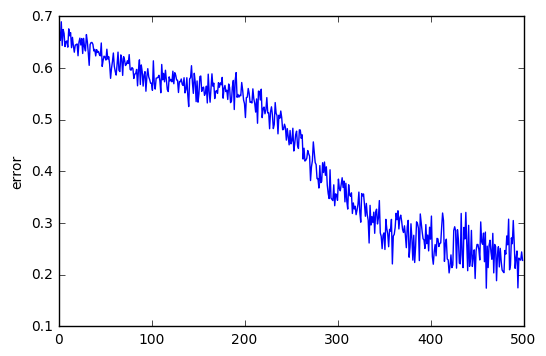

In [17]:
if problem == 1:
    TrDat = np.loadtxt("train.csv", delimiter=',')  # Iris classification problem (UCI dataset)
    TesDat = np.loadtxt("test.csv", delimiter=',')  #
    Hidden = 6
    Input = 4
    Output = 2
    TrSamples = 110
    TestSize = 40
    learnRate = 0.1
    TrainData = normalisedata(TrDat, Input, Output)
    TestData = normalisedata(TesDat, Input, Output)
    MaxTime = 500
    MinCriteria = 95  # stop when learn 95 percent

if problem == 2:
    TrainData = np.loadtxt("4bit.csv", delimiter=',')  # 4-bit parity problem
    TestData = np.loadtxt("4bit.csv", delimiter=',')  #
    Hidden = 4
    Input = 4
    Output = 1
    TrSamples = 16
    TestSize = 16
    learnRate = 0.9
    MaxTime = 3000
    MinCriteria = 95  # stop when learn 95 percent

if problem == 3:
    TrainData = np.loadtxt("xor.csv", delimiter=',')  # 4-bit parity problem
    TestData = np.loadtxt("xor.csv", delimiter=',')  #
    Hidden = 3
    Input = 2
    Output = 1
    TrSamples = 4
    TestSize = 4
    learnRate = 0.9
    MaxTime = 500
    MinCriteria = 100  # stop when learn 95 percent

print(TrainData)

print('printed data. now we use FNN for training ...')

layers = [Input, Hidden, Output]
MaxRun = 10  # number of experimental runs

trainTolerance = 0.2  # [eg 0.15 would be seen as 0] [ 0.81 would be seen as 1]
testTolerance = 0.49

trainPerf = np.zeros(MaxRun)
testPerf = np.zeros(MaxRun)

trainMSE = np.zeros(MaxRun)
testMSE = np.zeros(MaxRun)
Epochs = np.zeros(MaxRun)
Time = np.zeros(MaxRun)

stocastic = 1  # 0 if vanilla (batch mode)

for run in range(0, MaxRun):
    print(run, 'is the experimental run')
    fnnSGD = Network(layers, TrainData, TestData, MaxTime, learnRate, MinCriteria)
    start_time = time.time()
    (erEp, trainMSE[run], trainPerf[run], Epochs[run]) = fnnSGD.backpropagation(stocastic, trainTolerance)
    Time[run] = time.time() - start_time
    (testMSE[run], testPerf[run]) = fnnSGD.TestNetwork(TestData, testTolerance)

print(trainPerf, 'train perf % for n exp')
print(testPerf, 'test  perf % for n exp')
print(trainMSE, 'train mean squared error for n exp')
print(testMSE, 'test mean squared error for n exp')

print('mean and std for training perf %')
print(np.mean(trainPerf), np.std(trainPerf))

print('mean and std for test perf %')
print(np.mean(testPerf), np.std(testPerf))

print('mean and std for time in seconds')
print(np.mean(Time), np.std(Time))

plt.figure()
plt.plot(erEp)
plt.ylabel('error')
#plt.savefig(str(problem) + 'out.png')